# Visualizing the distribution of totals
This script uses data from the OpenPowerlifting project (https://www.openpowerlifting.org). <br>
You may download a copy of the data at https://gitlab.com/openpowerlifting/opl-data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bisect
from scipy import stats
import re
import math

%matplotlib inline

In [2]:
data_types = {
              'Name': str,
              'Sex': str,
              'Event': str,
              'Equipment': str,
              'BodyweightKg': float,
              'Tested': str,
              'TotalKg': float,
              'Place': str
             }

opl = pd.read_csv('openpowerlifting.csv', dtype=data_types, usecols=list(data_types))

In [3]:
opl['Total'] = opl['TotalKg'].apply(lambda x: x*2.20462)

In [4]:
opl['Tested'].fillna('No', inplace=True)

### Parameters
**Weight classes**: 44, 48, 52, 56, 60, 67.5, 75, 82.5, 90, 90+, 100, 110, 125, 140, 140+ <br>
**Tested**: Use 'Yes' for tested and both 'Yes' and 'No' for untested.

In [5]:
bw_range_low = 100
# use bw_range_high = 999 for SHW
bw_range_high = 110
sex = 'M'
equipment = ['Wraps']
tested = ['Yes', 'No']

opl_name = 'Casey Williams #1'

In [6]:
parameter_mask = (
                  (opl['BodyweightKg'] > bw_range_low)
                  & (opl['BodyweightKg'] <= bw_range_high)
                  & (opl.Sex == sex)
                  & (opl['Tested'].isin(tested))
                  & (opl.Equipment.isin(equipment))
                  & (opl.Event == 'SBD')
                  & (opl.Total.notna())
                  & (~ opl['Place'].isin(['DQ', 'DD', 'NS']))
                 )

opl_filtered = opl[parameter_mask]

In [7]:
best_totals = opl_filtered.groupby('Name')['Total'].max()

In [8]:
my_best_total = opl_filtered.loc[opl_filtered['Name'] == opl_name]['Total'].max()

### Histogram

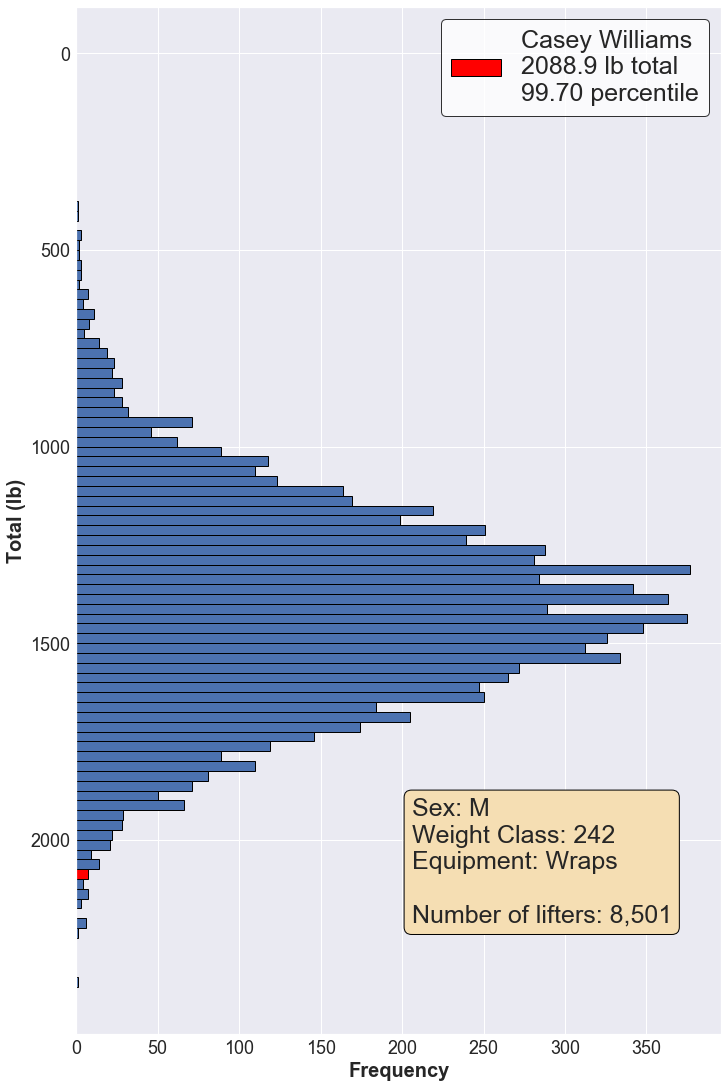

In [9]:
sns.set()

fig = plt.figure(figsize=(10, 15), constrained_layout=True)

ax = fig.add_subplot()

binsize = 25
kg_bins = np.arange(0, max(best_totals) + (25 - max(best_totals) % 25) + 1, binsize) # 25 lb bins

n, bins, patches = ax.hist(best_totals, bins=kg_bins, orientation='horizontal', edgecolor='black')

# CHART FORMATTING
ax.invert_yaxis()
ax.set_xlabel('Frequency', size=20, fontweight='bold')
ax.set_ylabel('Total (lb)', size=20, fontweight='bold')
plt.yticks(size=18)
plt.xticks(size=18)
ax.tick_params(axis='both', which='major', pad=0)

# MY BIN (rightmost value less than or equal to my_total)
bisect_index = bisect.bisect_right(bins, my_best_total)

if bisect_index == len(bins):
    index_to_highlight = -1
else:
    index_to_highlight = bisect_index - 1
    
patches[index_to_highlight].set_facecolor('red')

# LEGEND
percentile = stats.percentileofscore(best_totals, my_best_total, kind='mean')
actual_name = re.sub(r' #\d', '', opl_name)
label = [f'{actual_name}\n{my_best_total:.1f} lb total\n{percentile:.2f} percentile']
ax.legend([patches[index_to_highlight]], label, facecolor='white', edgecolor='black', fontsize=25)

# TEXTBOX
if bw_range_high == 999:
    weight_class = 'SHW'
else:
    weight_class = math.floor(bw_range_high*2.20462)
    
if 'Yes' in tested and len(tested) == 1:
    is_tested = '\nDrug-Tested: Yes'
else:
    is_tested = ''

parameters = '\n'.join((
   f'Sex: {sex}',
   f'Weight Class: {weight_class}',
   f'Equipment: {" + ".join(equipment)}' + is_tested,
   '\n'
   f'Number of lifters: {best_totals.count():,}'))

props = dict(boxstyle='round', facecolor='wheat', edgecolor='black')

ax.text(0.52, 0.23, parameters, transform=ax.transAxes, fontsize=25, verticalalignment='top', bbox=props)

# plt.savefig(actual_name, bbox_inches='tight')

plt.show()

### Descriptive statistics

In [10]:
pd.set_option('precision', 1)
best_totals.describe(percentiles=[.25, .50, .75, .99]).to_frame()

,Total
count,8501.0
mean,1413.9
std,251.6
min,396.8
25%,1251.1
50%,1420.0
75%,1581.8
99%,1984.2
max,2358.9
